# 2. Custom training

### Introducción

En esta notebook se mostrará cómo crear trabajos de entrenamiento custom (es decir, sin AutoML) en Vertex.

Partimos con los siguientes elementos:

- La carpeta traincontainer donde se almacenan los archivos clave.
- Dentro de esta carpeta, tenemos un Dockerfile con el que construiremos la imagen que será enviada a Google Container Registry (GCR) para su uso en el entrenamiento.
- También hay una carpeta llamada trainer, donde se encuentra el código de entrenamiento.
- Un bucket ya creado donde se almacenarán los distintos artefactos.

In [1]:
!tree 

.
├── 02_customtrain.ipynb
├── batch_examples.csv
├── custom_train_pipeline.json
├── traincontainer
│   ├── Dockerfile
│   └── trainer
│       └── train.py
└── workshop-vertex-customtraining.json

2 directories, 6 files


Seguramente ahora veas que hay un json, vamos a ver de dónde sale hacia el final del proceso (se creó cuando ejecuté la notebook para ver que estuviera todo bien!).

En esta notebook se mostrará cómo crear trabajos de entrenamiento custom (es decir, sin AutoML) en Vertex.

Partimos con los siguientes elementos:

- La carpeta traincontainer donde se almacenan los archivos clave.
- Dentro de esta carpeta, tenemos un Dockerfile con el que construiremos la imagen que será enviada a Google Container Registry (GCR) para su uso en el entrenamiento.
- También hay una carpeta llamada trainer, donde se encuentra el código de entrenamiento.
- Un bucket ya creado donde se almacenarán los distintos artefactos.

## 1. Entrenamiento custom: Docker

### 1.1. Dockerfile

### Revisión de dockerfile y código de entrenamiento

Veamos lo que tiene la imagen:

In [2]:
!cat traincontainer/Dockerfile

FROM gcr.io/deeplearning-platform-release/sklearn-cpu.0-23
WORKDIR /

# Copies the trainer code to the docker image.
COPY trainer /trainer

RUN pip install sklearn google-cloud-bigquery joblib pandas google-cloud-storage

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.train"]


Lo único que hace es copiar el código de entrenamiento para poder ejecutarlo desde ahí e instalar algunas dependencias. Otro punto para destacar es que el FROM parte de una imagen ya preparada por Google, que en este caso es bastante sencilla. La lista completa se encuentra aquí: https://cloud.google.com/deep-learning-containers/docs/choosing-container

Veamos a continuación el código de entrenamiento:

### 1.2. Definición del modelo

**Importante:** El código que está subido al repo es de aplicación genérica y por eso hay una variable llamada *TU_BUCKET*. 

Para poder ejecutarlo, vas a tener que reemplazar el valor del bucket de referencia genérica por el tuyo.

In [11]:
!cat traincontainer/trainer/train.py

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from google.cloud import bigquery
from google.cloud import storage
from joblib import dump

import os
import pandas as pd

bqclient = bigquery.Client()
storage_client = storage.Client()

def download_table(bq_table_uri: str):
    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix):]

    table = bigquery.TableReference.from_string(bq_table_uri)
    rows = bqclient.list_rows(
        table,
    )
    return rows.to_dataframe(create_bqstorage_client=False)

# These environment variables are from Vertex AI managed datasets
training_data_uri = os.environ["AIP_TRAINING_DATA_URI"]
test_data_uri = os.environ["AIP_TEST_DATA_URI"]

# Download data into Pandas DataFrames, split into train / test
df = download_table(training_data_uri)
test_df = download_table(test_data_uri)
labels = df.pop("Class").tolist()


**Cosas importantes a considerar**:
- Especial atención a la línea 47 del código, donde está el bucket de referencia.

In [6]:
%%bash
sed -n 47p traincontainer/trainer/train.py

bucket = storage_client.get_bucket("TU_BUCKET")


- Al indicar el bucket le tenemos que decir el nombre, no el path, y es por eso es que no tiene el 'gs://' adelante.
- En este caso el código compone todas las partes del proceso: obtener la data, preprocesar, etc. Esto es posible porque es un caso relativamente chiquito, pero no afecta al verdadero propósito de esto, que es...
- ... entrenar el modelo desde acá y guardarlo en el bucket. Esto es lo que tiene que hacer sí o sí (y lo que tenemos que replicar).

### 1.3. Modificación del código

Ahora tenemos que cambiar esa línea de código, reemplazando un bucket por otro.

In [5]:
import os
PROJECT_ID = ""
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    
BUCKET_NAME = f'gs://{PROJECT_ID}-vertex-02-customtraining'

print('El nombre de tu bucket es: ', BUCKET_NAME)

El nombre de tu bucket es:  gs://vertex-playground-352219-vertex-02-customtraining


En mi caso, el nombre del bucket es el que vemos arriba, con la estructura que conocemos: el project ID primero y luego el nombre genérico. Cuando ejecutes esa celda, vas a ver el nombre de tu bucket.

Dentro de la carpeta traincontainer/train encontramos el archivo *train.py*. Hacemos doble click y reemplazamos la línea 47 con el nombre del bucket. 

Al terminar, te debería quedar algo así:

In [8]:
!cat traincontainer/trainer/train.py

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from google.cloud import bigquery
from google.cloud import storage
from joblib import dump

import os
import pandas as pd

bqclient = bigquery.Client()
storage_client = storage.Client()

def download_table(bq_table_uri: str):
    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix):]

    table = bigquery.TableReference.from_string(bq_table_uri)
    rows = bqclient.list_rows(
        table,
    )
    return rows.to_dataframe(create_bqstorage_client=False)

# These environment variables are from Vertex AI managed datasets
training_data_uri = os.environ["AIP_TRAINING_DATA_URI"]
test_data_uri = os.environ["AIP_TEST_DATA_URI"]

# Download data into Pandas DataFrames, split into train / test
df = download_table(training_data_uri)
test_df = download_table(test_data_uri)
labels = df.pop("Class").tolist()


La línea 47 debería entonces quedar así:

In [9]:
%%bash
sed -n 47p traincontainer/trainer/train.py

bucket = storage_client.get_bucket("vertex-playground-352219-vertex-02-customtraining")


### 1.4. Construir la imagen

En este paso tenemos que construir el contenedor de Docker, usando para ello el Dockerfile y el código que acabamos de modificar.

En el contexto de GCP, el microservicio dedicado al almacenamiento y manejo de imágenes de Docker se llama Google Container Registry (GCR) y es ahí donde tenemos que subir lo que vamos a construir.

Veamos la URI donde se alojará:

Vamos a hacer el build de la imagen desde una terminal. Primero necesitamos armar el DOCKER_IMAGE_URI, que es donde quedará la imagen.

In [12]:
DOCKER_IMAGE_URI = f'gcr.io/{PROJECT_ID}/workshop-sklearn-beans:v1'
f'La uri de la imagen es: {DOCKER_IMAGE_URI}'

'La uri de la imagen es: gcr.io/vertex-playground-352219/workshop-sklearn-beans:v1'

La próxima celda ejecuta código bash para subir la imagen a GCR. Lo que vas a ver en la ejecución de la celda es mi resultado: lo que tenés que hacer es descomentar la celda y ejecutarla **solo una vez**, de forma tal que quede tu imagen que contiene las especificaciones de tu bucket quede alojada en el registro.

In [14]:
# !docker build ./traincontainer/ -t $DOCKER_IMAGE_URI

Sending build context to Docker daemon  8.704kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/sklearn-cpu.0-23
 ---> 9fbcb0ae18e1
Step 2/5 : WORKDIR /
 ---> Using cache
 ---> a0ff79fe3773
Step 3/5 : COPY trainer /trainer
 ---> 646558fe9114
Step 4/5 : RUN pip install sklearn google-cloud-bigquery joblib pandas google-cloud-storage
 ---> Running in ee582b665795
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=bbaf7b992db548bf6b40757aabd49b1df025ad7ee589c6761da9278bb4489a1e
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Removing intermediate container ee582b665795
 ---> 874a477241ba
Step 5/5 : ENTRYPOINT ["python", "-m", "trainer.train"]
 ---> Running in 3ea398b74b9a
Removing intermediate container 3ea398b74b9a
 ---> 334318616688
Successfully built 334318616

Usamos un poco más de bash para subir la imagen de Docker cuyo nombre acabamos de generar. Aplica lo mismo que arriba: se corre **sólo una vez**, para subir tu imagen a tu repositorio.

In [16]:
# !docker push $DOCKER_IMAGE_URI

The push refers to repository [gcr.io/vertex-playground-352219/workshop-sklearn-beans]

2b2f82bd: Preparing 
9b334c4c: Preparing 
e09ebc54: Preparing 
f0ab3217: Preparing 
22d8d85c: Preparing 
b01c5179: Preparing 
e696ff5b: Preparing 
43fff4a9: Preparing 
9c14a32d: Preparing 
d198ee7d: Preparing 
46a1d19e: Preparing 
b83c1c63: Preparing 
c31d7bf8: Preparing 
03bffb47: Preparing 
d4d6cdf8: Preparing 
bf18a086: Preparing 
c4cf558f: Preparing 
bf18a086: Preparing 
6f75faab: Preparing 
b334c4c: Pushed lready exists 4kBv1: digest: sha256:4a0ac23d218e2ddf3086da74c6307fad45d9638c2602a10df3f93abda5dbc1f4 size: 4703


Si todo salió bien, deberíamos poder ver la imagen en el listado de las que están en GCR. Pueden buscar el servicio y revisarlo, como vemos a continuación:

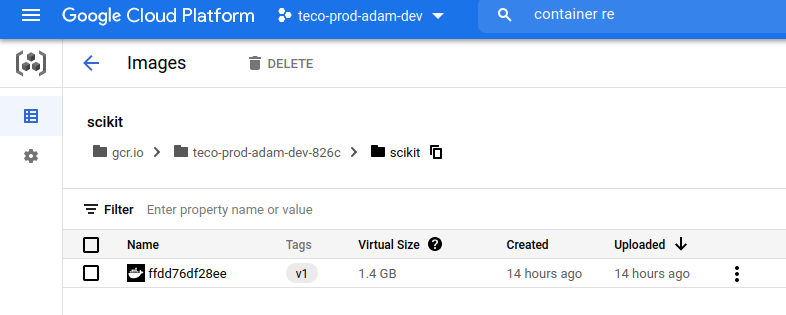

## 2. Configurar la predicción batch

Este ejemplo crea un archivo sobre el cual hará predicciones y lo sube al bucket.
Primero crea el archivo:

In [17]:
%%writefile batch_examples.csv
Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
23288,558.113,207.567738,143.085693,1.450653336,0.7244336162,23545,172.1952453,0.8045881703,0.9890847314,0.9395021523,0.8295857874,0.008913077034,0.002604069884,0.6882125787,0.9983578734
23689,575.638,205.9678003,146.7475015,1.403552348,0.7016945718,24018,173.6714472,0.7652721693,0.9863019402,0.8983750474,0.8431970773,0.00869465998,0.002711119968,0.7109813112,0.9978994889
23727,559.503,189.7993849,159.3717704,1.190922235,0.5430731512,24021,173.8106863,0.8037601626,0.9877607094,0.952462433,0.9157600082,0.007999299741,0.003470231343,0.8386163926,0.9987269085
31158,641.105,212.0669751,187.1929601,1.132879009,0.4699241567,31474,199.1773023,0.7813134733,0.989959967,0.9526231013,0.9392188582,0.0068061806,0.003267009878,0.8821320637,0.9993488983
32514,649.012,221.4454899,187.1344232,1.183349841,0.5346736437,32843,203.4652564,0.7849831,0.9899826447,0.9700068737,0.9188051492,0.00681077351,0.002994124691,0.8442029022,0.9989873701
33078,659.456,235.5600775,178.9312328,1.316483846,0.6503915309,33333,205.2223615,0.7877214708,0.9923499235,0.9558229607,0.8712102818,0.007121351881,0.002530662194,0.7590073551,0.9992209221
33680,683.09,256.203255,167.9334938,1.525623324,0.7552213942,34019,207.081404,0.80680321,0.9900349805,0.9070392732,0.8082699962,0.007606985006,0.002002710402,0.6533003868,0.9966903078
33954,716.75,277.3684803,156.3563259,1.773951126,0.825970469,34420,207.9220419,0.7994819873,0.9864613597,0.8305492781,0.7496238998,0.008168948587,0.001591181142,0.5619359911,0.996846984
36322,719.437,272.0582306,170.8914975,1.591993952,0.7780978465,36717,215.0502424,0.7718560075,0.9892420405,0.8818487005,0.7904566678,0.007490177594,0.001803782407,0.6248217437,0.9947124371
36675,742.917,285.8908964,166.8819538,1.713132487,0.8119506999,37613,216.0927123,0.7788277766,0.9750618137,0.8350248381,0.7558572692,0.0077952528,0.001569528272,0.5713202115,0.9787472145
37454,772.679,297.6274753,162.1493177,1.835514817,0.8385619338,38113,218.3756257,0.8016695205,0.9827093118,0.7883332637,0.7337213257,0.007946480356,0.001420623993,0.5383469838,0.9881438654
37789,766.378,313.5680678,154.3409867,2.031657789,0.8704771226,38251,219.3500608,0.7805870567,0.9879218844,0.8085170916,0.6995293312,0.008297866252,0.001225659709,0.4893412853,0.9941740339
47883,873.536,327.9986493,186.5201272,1.758516115,0.822571799,48753,246.9140116,0.7584464543,0.9821549443,0.7885506623,0.7527897207,0.006850002074,0.00135695419,0.5666923636,0.9965376533
49777,861.277,300.7570338,211.6168613,1.42123379,0.7105823885,50590,251.7499649,0.8019106536,0.9839296304,0.843243269,0.8370542883,0.00604208839,0.001829706116,0.7006598815,0.9958014989
49882,891.505,357.1890036,179.8346914,1.986207449,0.8640114945,51042,252.0153467,0.7260210171,0.9772736178,0.7886896753,0.7055518063,0.007160679276,0.001094585314,0.4978033513,0.9887407248
53249,919.923,325.3866286,208.9174205,1.557489212,0.7666552108,54195,260.3818974,0.6966846347,0.9825445152,0.7907120655,0.8002231025,0.00611066177,0.001545654241,0.6403570138,0.9973491406
61129,964.969,369.3481688,210.9473449,1.750902193,0.8208567513,61796,278.9836198,0.7501135067,0.9892064211,0.8249553283,0.7553404711,0.006042110436,0.001213219664,0.5705392272,0.9989583843
61918,960.372,353.1381442,224.0962377,1.575832543,0.7728529173,62627,280.7782864,0.7539207091,0.9886790043,0.8436218213,0.7950947556,0.005703319619,0.00140599258,0.6321756704,0.9962029945
141953,1402.05,524.2311633,346.3974998,1.513380332,0.7505863011,143704,425.1354762,0.7147107987,0.9878152313,0.9074598849,0.8109694843,0.003692991084,0.0009853172185,0.6576715044,0.9953071199
145285,1440.991,524.9567463,353.0769977,1.486805285,0.7400216694,146709,430.0960442,0.7860466375,0.9902937107,0.8792413513,0.8192980608,0.003613289371,0.001004269363,0.6712493125,0.9980170255
146153,1476.383,526.1933264,356.528288,1.475881001,0.7354662103,149267,431.3789276,0.7319360978,0.9791380546,0.8425962592,0.8198107159,0.003600290972,0.001003163512,0.6720896099,0.991924286


Writing batch_examples.csv


Lógicamente, este archivo no cuenta con las clases (dado que es lo que va a predecir). El paso siguiente es subirlo al bucket:

In [18]:
!gsutil cp batch_examples.csv $BUCKET_NAME

Copying file://batch_examples.csv [Content-Type=text/csv]...
/ [1 files][  4.0 KiB/  4.0 KiB]                                                
Operation completed over 1 objects/4.0 KiB.                                      


Si todo salió bien, deberíamos verlo en el bucket:

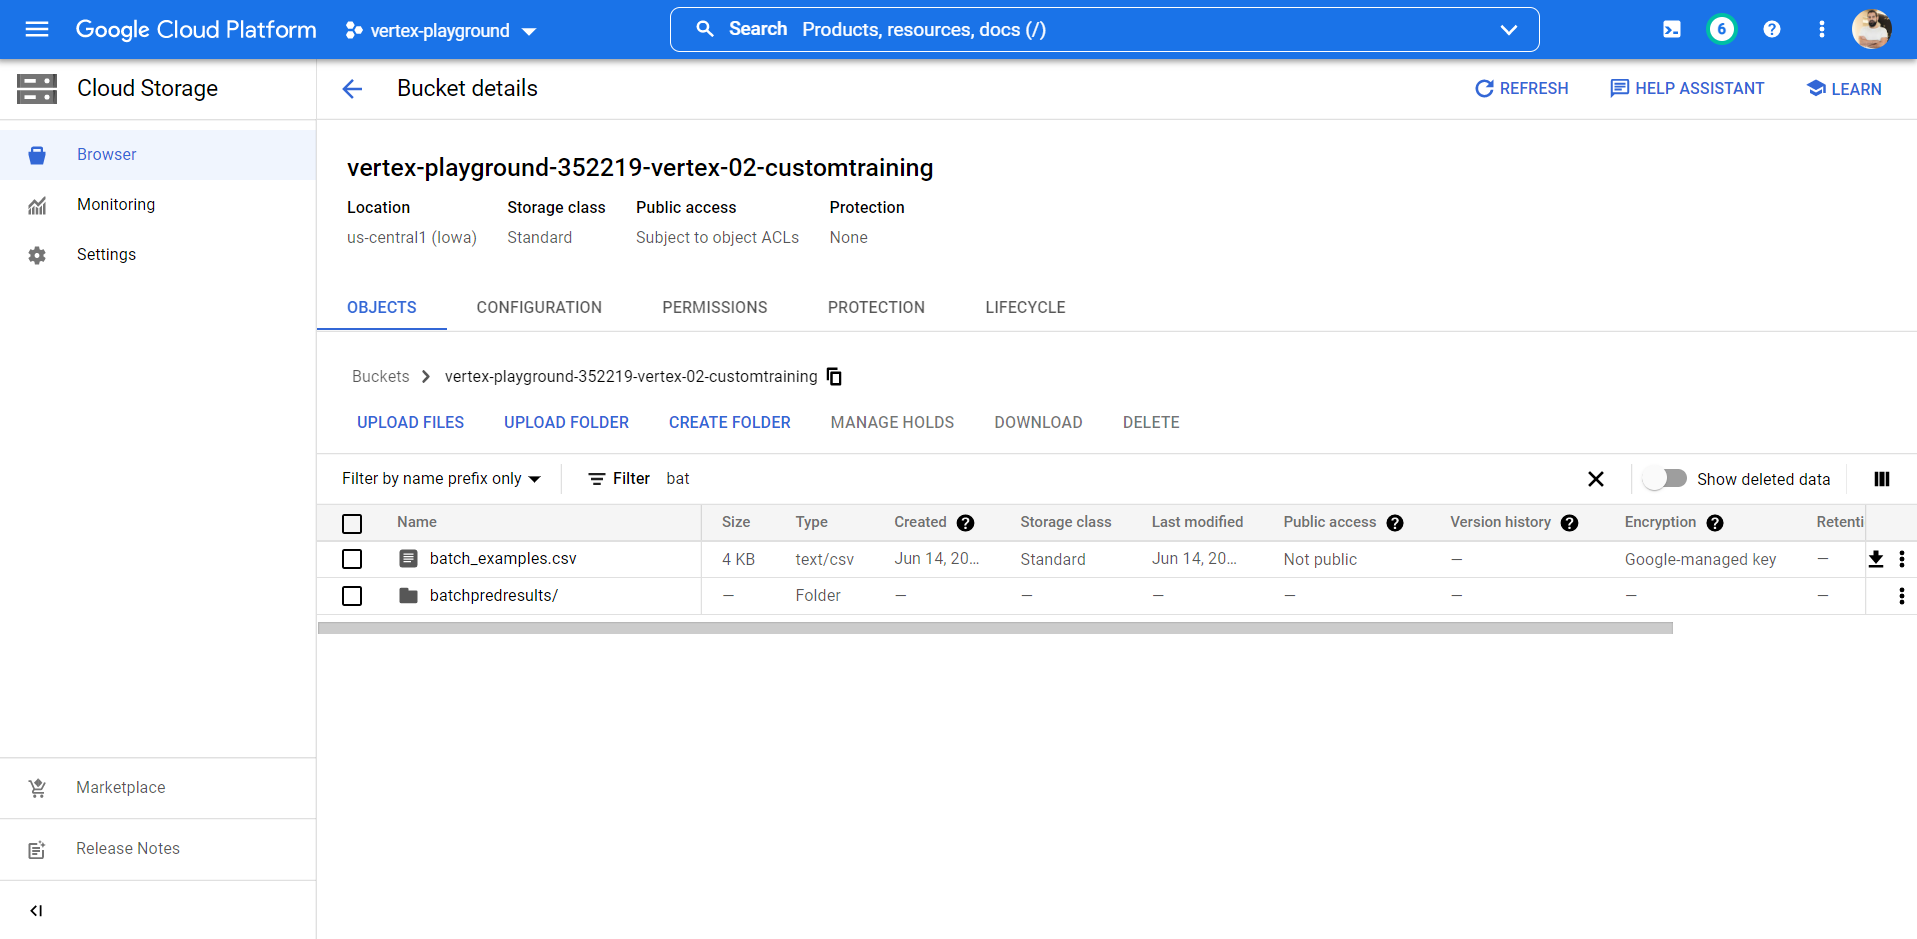

## 3. Armado del pipeline

¡Ahora sí, a lo que vinimos!

Este pipeline sencillo va hacer tres cosas:
- Crear un dataset de Vertex AI
- Correr un training job usando el container custom que armamos
- Correr un batch prediction job con el modelo entrenado.

En este caso, vamos a estar utilizando componentes preconstruidos de Kubeflow así que tenemos el camino un poco más allanado. 

Antes que nada, **recomiendo fuertemente reiniciar el kernel**.

Hecho eso, importamos algunas librerías y seteamos algunas variables que vamos a necesitar en el proceso:

In [2]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)
    
BUCKET_NAME = f'gs://{PROJECT_ID}-vertex-02-customtraining'

PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="us-central1"

PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

from kfp.v2 import compiler
from kfp.v2.dsl import pipeline

from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

PIPELINE_NAME = "workshop-vertex-customtraining"
PACKAGE_PATH = f"workshop-vertex-customtraining.json"
DISPLAY_RUN_NAME = f'{PIPELINE_NAME}-{TIMESTAMP}'

Project ID:  vertex-playground-352219
env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


Con todo esto, ahora sí podemos crear el pipeline.

In [3]:
@pipeline(
    name=PIPELINE_NAME,
    pipeline_root=PIPELINE_ROOT
)
def pipeline(
    bq_source: str = "bq://sara-vertex-demos.beans_demo.large_dataset",
    bucket: str = BUCKET_NAME,
    project: str = PROJECT_ID,
    gcp_region: str = REGION,
    bq_dest: str = "",
    container_uri: str = "",
    batch_destination: str = ""
):
    dataset_create_op = gcc_aip.TabularDatasetCreateOp(
        display_name="tabular-beans-dataset",
        bq_source=bq_source,
        project=project,
        location=gcp_region
    )

    training_op = gcc_aip.CustomContainerTrainingJobRunOp(
        display_name=DISPLAY_RUN_NAME,
        container_uri=container_uri,
        project=project,
        location=gcp_region,
        dataset=dataset_create_op.outputs["dataset"],
        staging_bucket=bucket,
        training_fraction_split=0.8,
        validation_fraction_split=0.1,
        test_fraction_split=0.1,
        bigquery_destination=bq_dest,
        model_serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
        model_display_name="scikit-beans-model-pipeline",
        machine_type="n1-standard-4",
    )
    batch_predict_op = gcc_aip.ModelBatchPredictOp(
        project=project,
        location=gcp_region,
        job_display_name=f"{PIPELINE_NAME}-predict",
        model=training_op.outputs["model"],
        gcs_source_uris=["{0}/batch_examples.csv".format(BUCKET_NAME)],
        instances_format="csv",
        gcs_destination_output_uri_prefix=batch_destination,
        machine_type="n1-standard-4"
    )


Este es el esqueleto básico del pipeline. Hay un par de variables que se le pasan desde la ejecución del pipeline (por ejemplo, el container_uri de la imagen que tiene el modelo adentro). Con esta definición, el próximo paso es compilarlo:

In [4]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path=PACKAGE_PATH
)


/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


Esto nos deja preparado un json que podemos reutilizar en otras ocasiones.

Vamos a capturar el timestamp actual y usarlo también como argumento en la definición del job del pipeline:

In [5]:
pipeline_job = aiplatform.PipelineJob(
    display_name=PIPELINE_NAME,
    template_path=PACKAGE_PATH,
    job_id=f'{PIPELINE_NAME}-{TIMESTAMP}',
    parameter_values={
        "project": PROJECT_ID,
        "bucket": BUCKET_NAME,
        "bq_dest": "bq://{0}".format(PROJECT_ID),
        "container_uri": "gcr.io/{0}/workshop-sklearn-beans:v1".format(PROJECT_ID),
        "batch_destination": "{0}/batchpredresults".format(BUCKET_NAME)
    },
    enable_caching=True,
)


Por último, sólo queda submitear el job:

In [6]:
pipeline_job.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/696333388420/locations/us-central1/pipelineJobs/workshop-vertex-customtraining-20220614185310
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/696333388420/locations/us-central1/pipelineJobs/workshop-vertex-customtraining-20220614185310')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/workshop-vertex-customtraining-20220614185310?project=696333388420


### Analizando los componentes

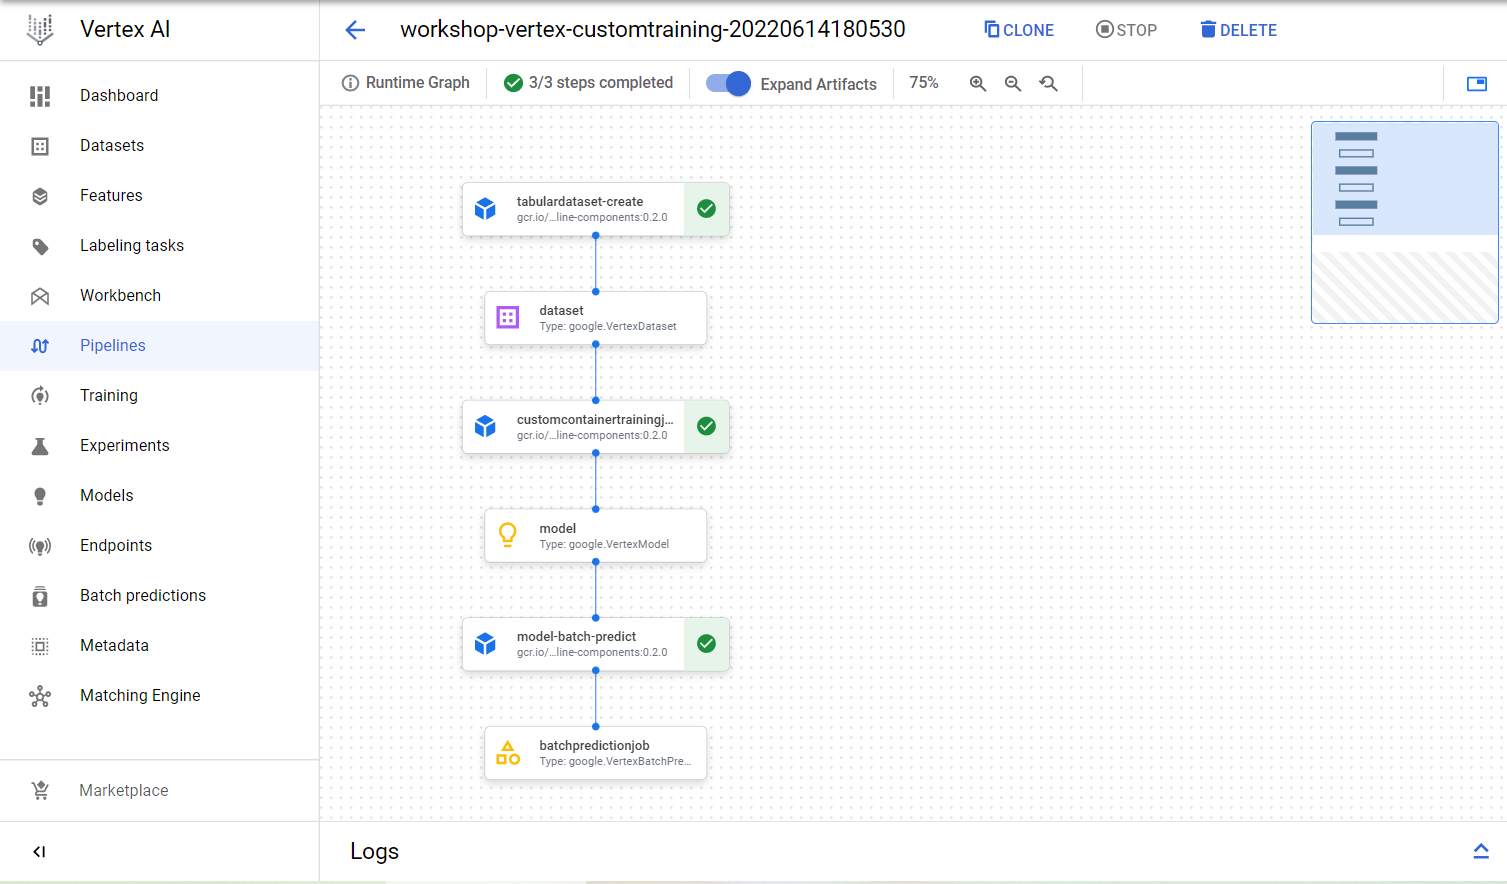

En la parte de Vertex -> Datasets vemos que está creado el dataset que preparamos desde el pipeline. Desde acá se puede usar este dataset para entrenar modelos custom o de AutoML. Un punto importante es que estos datasets manejados cuentan con una serie de variables que se usan en la parte siguiente del pipeline (como el split train/val/test).

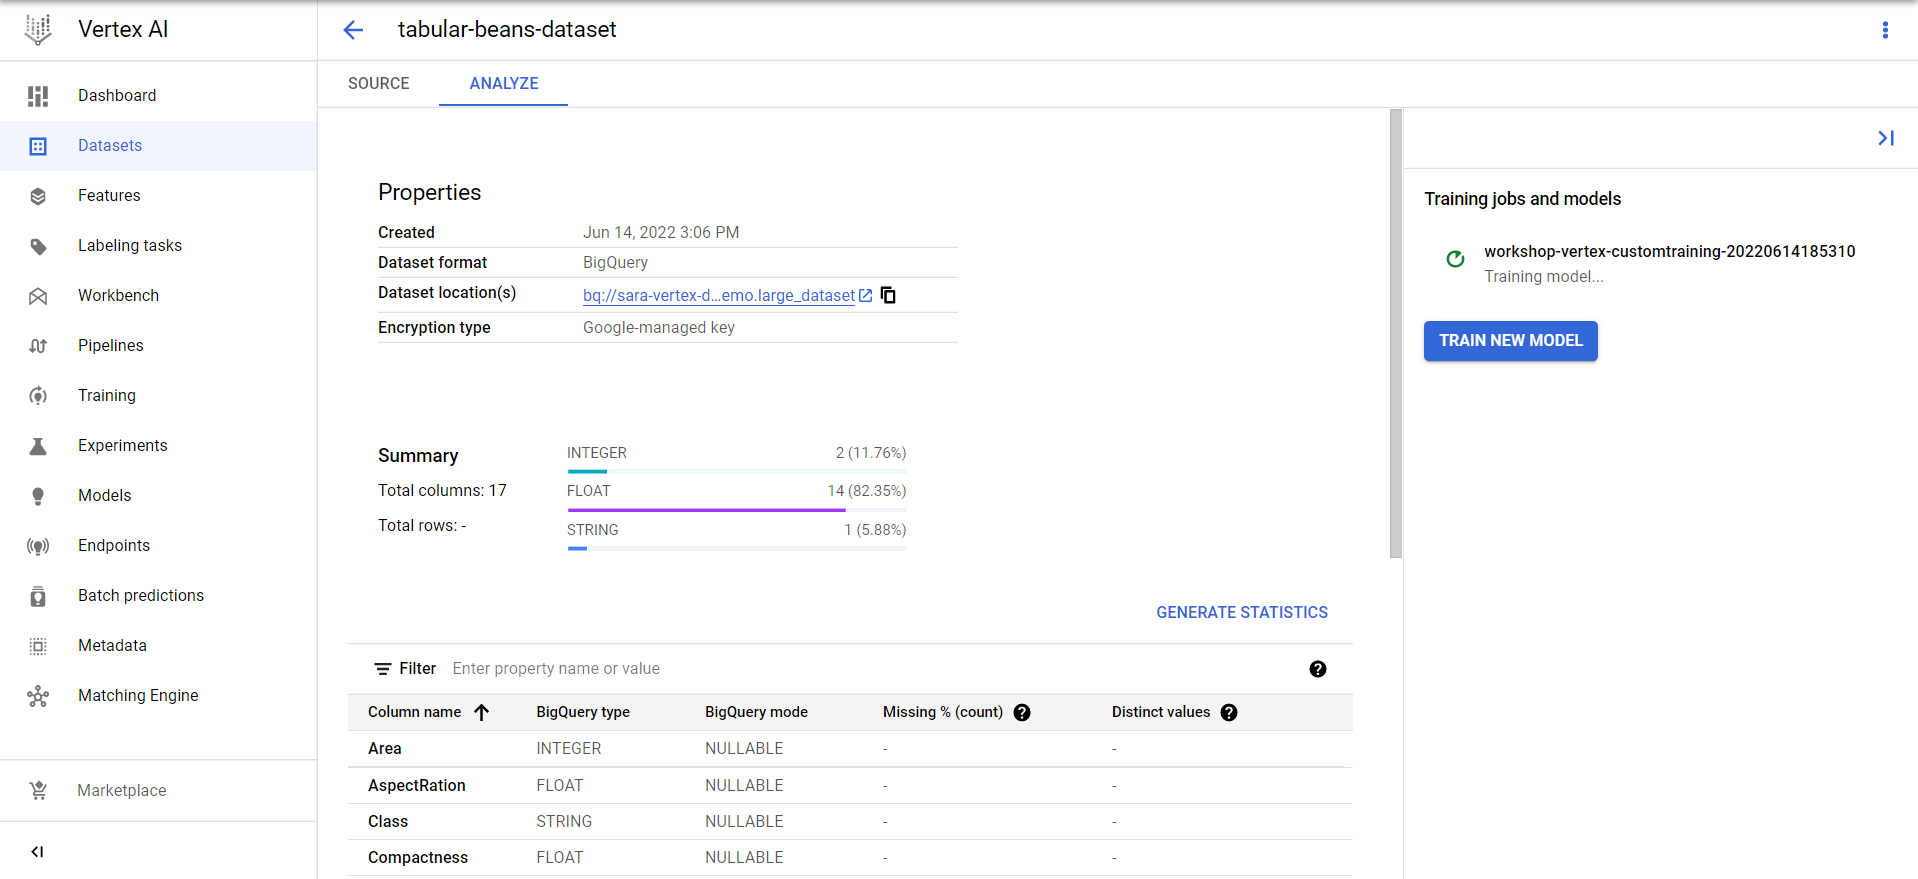

En la parte de Vertex -> Models podemos ver nuestro modelo ya preparado. 

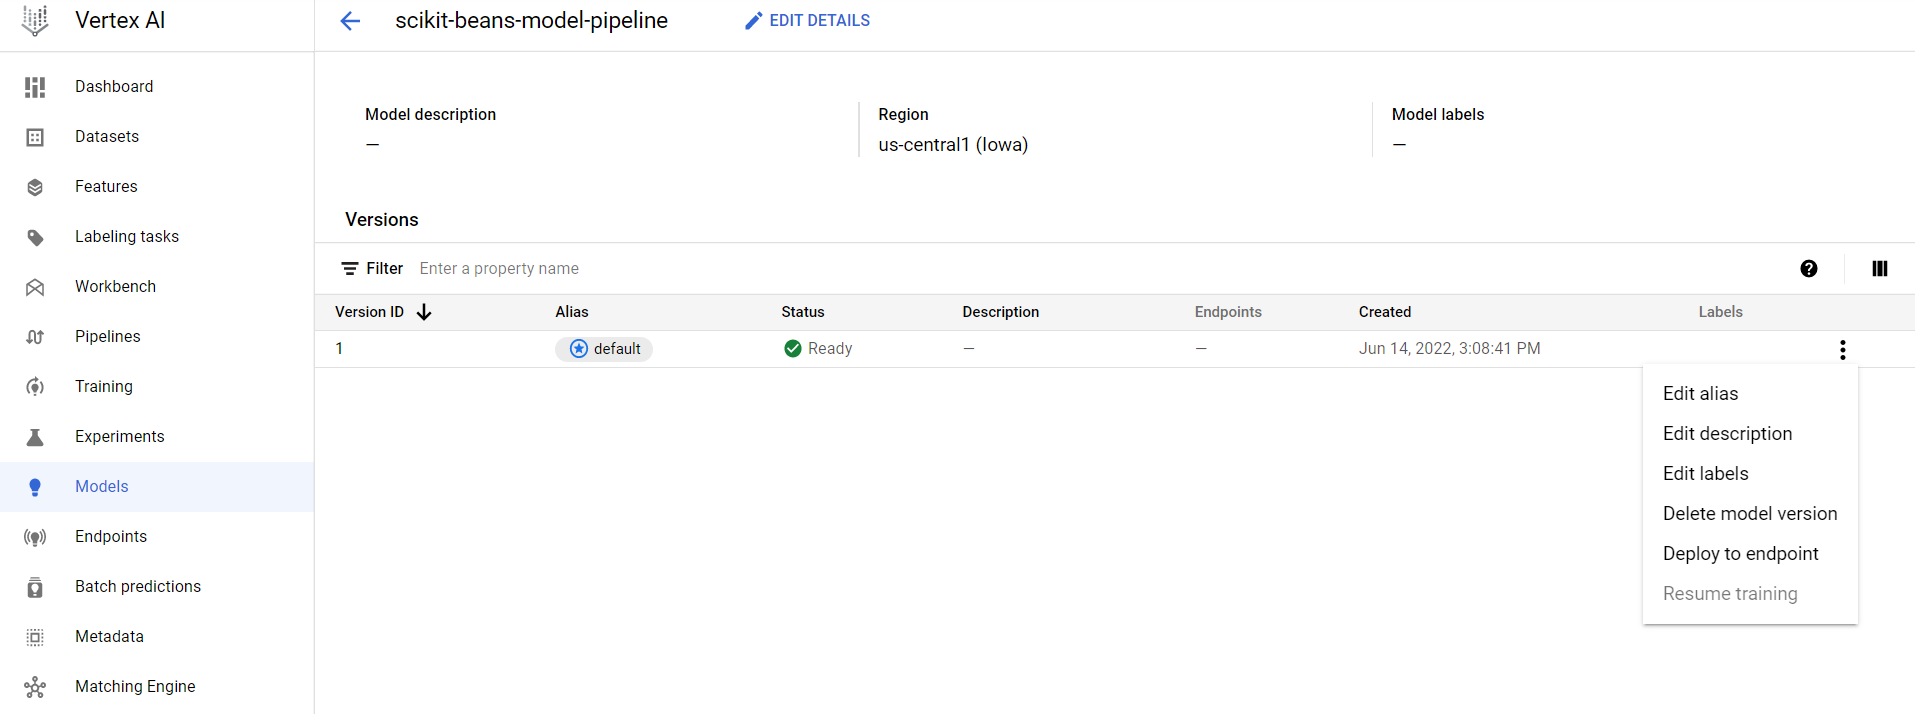

Por último, revisemos un poco qué pasó en el bucket donde se almacena todo:

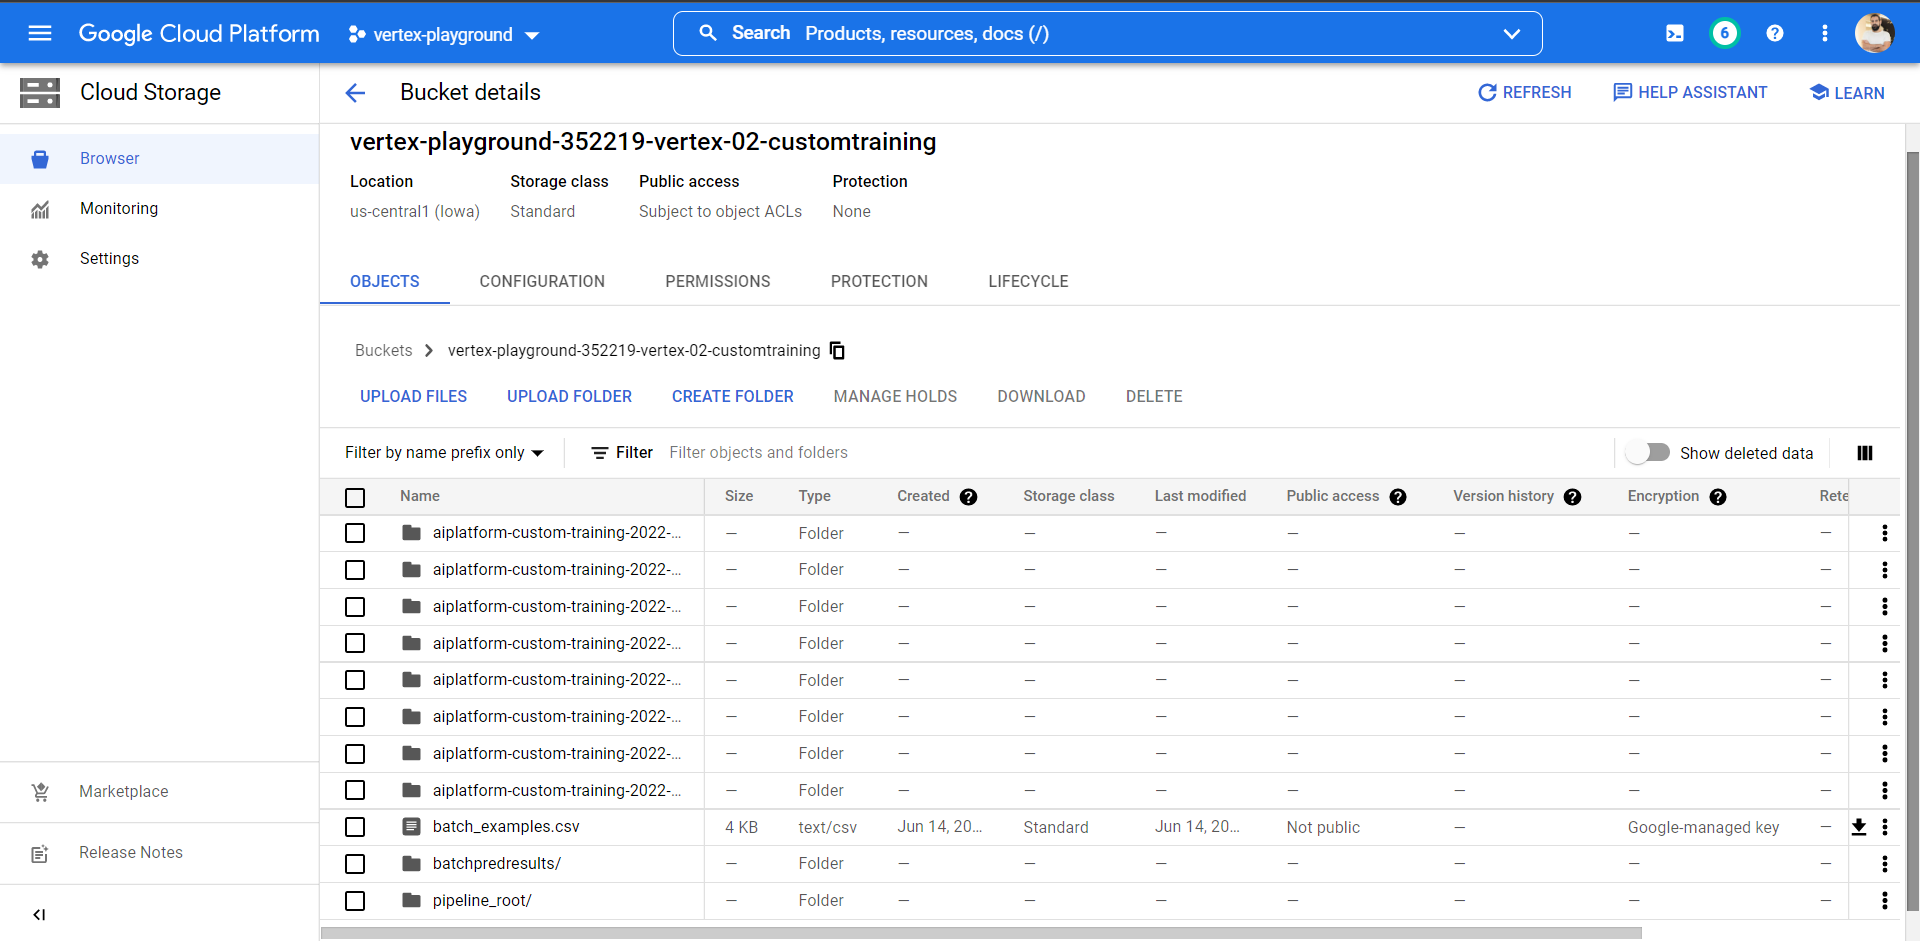

Vean qué rápido se va llenando de mugre! Por eso es tan importante una gestión correcta de artefactos y metadata (y ahí es lo que servicios como Vertex intentan aliviar, a su manera).

- Tenemos por un lado la carpeta donde se almacenan los resultados de la predcición (batchpredresults), que es donde va a buscar todo la parte de Vertex Models que vimos arriba.
- En la carpeta pipeline_root se almacenan artefactos de las distintas ejecuciones. Creo que no vamos a encontrar nada muy útil ahí.
- Pero en las carpetas de los distintos jobs de training vemos que está el modelo terminado:

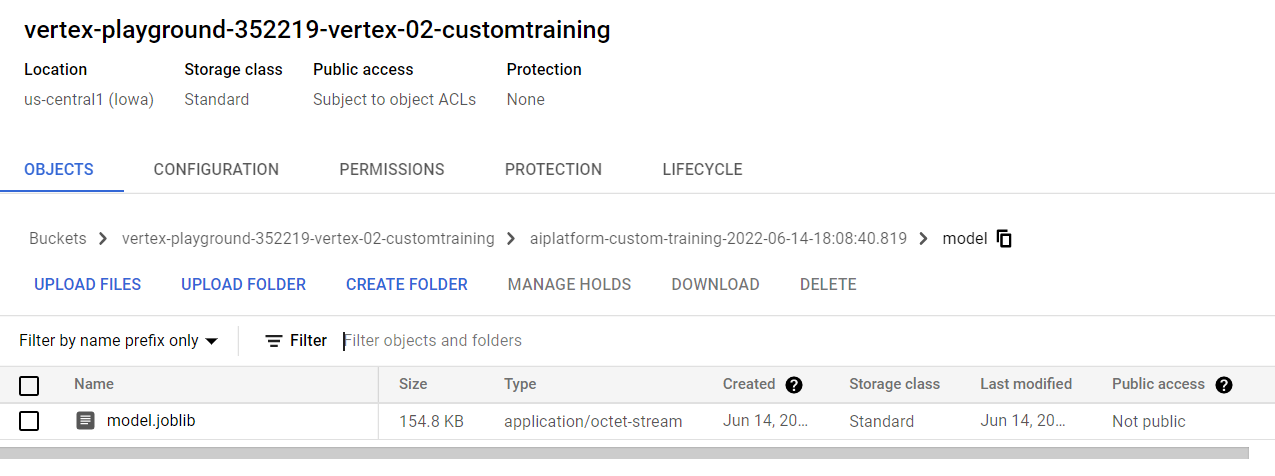